In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import optuna
import time
import copy
import pickle
from barbar import Bar
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
%matplotlib inline

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
#from torchsummary import summary

from tqdm import tqdm
from pathlib import Path
import gc
RANDOMSTATE = 0

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
torch.cuda.is_available()

True

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("theaayushbajaj/cbir-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\Intern\.cache\kagglehub\datasets\theaayushbajaj\cbir-dataset\versions\1


In [5]:
from pathlib import Path
import pandas as pd
import os

# Define dataset path
datasetPath = Path(r'C:\Users\Intern\.cache\kagglehub\datasets\theaayushbajaj\cbir-dataset\versions\1')

# Prepare DataFrame
df = pd.DataFrame()

# List all files in the directory
df['image'] = [f for f in os.listdir(datasetPath) if os.path.isfile(datasetPath / f)]

# Prepend the directory path to each file name
df['image'] = df['image'].apply(lambda x: str(datasetPath / x))

# Display the DataFrame
print(df.head())


Empty DataFrame
Columns: [image]
Index: []


In [6]:
import os

# List files in the dataset path
dataset_path = str(path)
files = os.listdir(dataset_path)
print("Files in dataset:", files)


Files in dataset: ['dataset']


In [7]:
# Update dataset_path to point to the "dataset" folder
dataset_path = os.path.join(dataset_path, 'dataset')

# List files in the "dataset" subfolder
files = os.listdir(dataset_path)
print("Files in 'dataset' subdirectory:", files)


Files in 'dataset' subdirectory: ['0.jpg', '1.jpg', '10.jpg', '100.jpg', '1000.jpg', '1001.jpg', '1002.jpg', '1003.jpg', '1004.jpg', '1005.jpg', '1006.jpg', '1007.jpg', '1008.jpg', '1009.jpg', '101.jpg', '1010.jpg', '1011.jpg', '1012.jpg', '1013.jpg', '1014.jpg', '1015.jpg', '1016.jpg', '1017.jpg', '1018.jpg', '1019.jpg', '102.jpg', '1020.jpg', '1021.jpg', '1022.jpg', '1023.jpg', '1024.jpg', '1025.jpg', '1026.jpg', '1027.jpg', '1028.jpg', '1029.jpg', '103.jpg', '1030.jpg', '1031.jpg', '1032.jpg', '1033.jpg', '1034.jpg', '1035.jpg', '1036.jpg', '1037.jpg', '1038.jpg', '1039.jpg', '104.jpg', '1040.jpg', '1041.jpg', '1042.jpg', '1043.jpg', '1044.jpg', '1045.jpg', '1046.jpg', '1047.jpg', '1048.jpg', '1049.jpg', '105.jpg', '1050.jpg', '1051.jpg', '1052.jpg', '1053.jpg', '1054.jpg', '1055.jpg', '1056.jpg', '1057.jpg', '1058.jpg', '1059.jpg', '106.jpg', '1060.jpg', '1061.jpg', '1062.jpg', '1063.jpg', '1064.jpg', '1065.jpg', '1066.jpg', '1067.jpg', '1068.jpg', '1069.jpg', '107.jpg', '1070.jpg'

In [8]:
from pathlib import Path
import pandas as pd

# Prepare a DataFrame for image files
df = pd.DataFrame()
df['image'] = [str(Path(dataset_path) / f) for f in os.listdir(dataset_path) if os.path.isfile(Path(dataset_path) / f)]

# Show the first few rows
print(df.head())


                                               image
0  C:\Users\Intern\.cache\kagglehub\datasets\thea...
1  C:\Users\Intern\.cache\kagglehub\datasets\thea...
2  C:\Users\Intern\.cache\kagglehub\datasets\thea...
3  C:\Users\Intern\.cache\kagglehub\datasets\thea...
4  C:\Users\Intern\.cache\kagglehub\datasets\thea...


In [9]:
df.shape

(4738, 1)

In [10]:
import os

# Define the directory to save the file
target_directory = r"C:\Users\Intern\Untitled Folder"
# Specify the file path and name for the dataset file
dataset_file_path = os.path.join(target_directory, 'cb_dataset.py')

# Code for the dataset class
dataset_code = r'''
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class CBIRDataset(Dataset):
    def __init__(self, dataFrame):
        self.dataFrame = dataFrame
        
        # Define the transformations (to tensor + normalization)
        self.transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('slicing is not supported')
        
        # Get the row from the DataFrame
        row = self.dataFrame.iloc[key]
        
        # Open the image and apply transformations
        image = self.transformations(Image.open(row['image']))
        
        return image
    
    def __len__(self):
        return len(self.dataFrame.index)

# Example usage:
# Assuming 'df' is your pandas DataFrame with a column 'image' containing image paths
# dataset = CBIRDataset(dataFrame=df)
'''

# Write the code to the dataset.py file
with open(dataset_file_path, 'w') as f:
    f.write(dataset_code)

print(f"dataset.py file created at: {dataset_file_path}")


dataset.py file created at: C:\Users\Intern\Untitled Folder\cb_dataset.py


In [11]:
# Intermediate Function to process data from the data retrival class
def prepare_data(DF):
    trainDF, validateDF = train_test_split(DF, test_size=0.15, random_state=RANDOMSTATE)
    train_set = CBIRDataset(trainDF)
    validate_set = CBIRDataset(validateDF)
    
    return train_set, validate_set

In [12]:
class AutoEncoder(nn.Module):
    def __init__(self):  # Add the missing underscore
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=1, padding=0),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=1, padding=1),
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(3, 3), stride=2, padding=0),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(3, 3), stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(3, 3), stride=2, padding=1),
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=(4, 4), stride=2, padding=2),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [13]:
from torchsummary import summary

# Assuming `device` is defined (e.g., "cuda" or "cpu")
device = "cuda" if torch.cuda.is_available() else "cpu"

# Instantiate the model and display the summary
model = AutoEncoder().to(device)
summary(model, input_size=(3, 512, 512))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
         MaxPool2d-5         [-1, 64, 256, 256]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 126, 126]         147,584
              ReLU-9        [-1, 128, 126, 126]               0
        MaxPool2d-10          [-1, 128, 63, 63]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

In [19]:
import torch
import time
import copy
import numpy as np
from tqdm import tqdm as Bar  # Assuming you have a Bar function for progress bars
from torch.utils.data import DataLoader
from cb_dataset import CBIRDataset

# Assuming other imports like your model and dataset classes are here

def load_ckpt(checkpoint_fpath, model, optimizer):
    """Load a checkpoint to resume training from a saved state."""
    checkpoint = torch.load(checkpoint_fpath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return model, optimizer, checkpoint['epoch']

def save_checkpoint(state, filename):
    """Save checkpoint if a new best is achieved"""
    print("=> Saving a new best")
    torch.save(state, filename)

def train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=25):
    """Train and validate the model, saving the best weights based on validation loss."""
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data
            for idx, inputs in enumerate(Bar(dataloaders[phase])):
                inputs = inputs.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, inputs)

                    # Backward pass and optimize only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f}')

            # Deep copy the model if validation loss is improved
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                save_checkpoint(state={
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_loss': best_loss
                }, filename=f'ckpt_epoch_{epoch}.pt')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, optimizer, best_loss


if __name__ == '__main__':
    # Assuming 'model', 'criterion', 'optimizer', and dataloaders are defined here
    # Example setup (you need to adjust it according to your code):
    
    # Instantiate your model
    model = AutoEncoder()  # Replace with your actual model class
    model.to(device)

    # Define loss function and optimizer
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Example optimizer

    # Load your data (ensure 'train_set', 'validate_set' are loaded)
    train_set, validate_set = prepare_data(df)  # Assuming df is your dataset
    dataloaders = {
        'train': DataLoader(train_set, batch_size=8, shuffle=True),
        'val': DataLoader(validate_set, batch_size=8, shuffle=False)
    }
    
    dataset_sizes = {'train': len(train_set), 'val': len(validate_set)}

    # Train the model
    trained_model, trained_optimizer, best_loss = train_model(model, criterion, optimizer, dataloaders, dataset_sizes, num_epochs=10)

    print(f"Training complete. Best validation loss: {best_loss}")


Epoch 1/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 504/504 [09:21<00:00,  1.11s/it]


train Loss: 0.0935


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [00:17<00:00,  5.12it/s]


val Loss: 0.0598
=> Saving a new best

Epoch 2/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 504/504 [09:20<00:00,  1.11s/it]


train Loss: 0.0532


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [00:16<00:00,  5.33it/s]


val Loss: 0.0453
=> Saving a new best

Epoch 3/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 504/504 [09:27<00:00,  1.13s/it]


train Loss: 0.0431


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [00:16<00:00,  5.25it/s]


val Loss: 0.0411
=> Saving a new best

Epoch 4/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 504/504 [09:27<00:00,  1.13s/it]


train Loss: 0.0391


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [00:17<00:00,  5.12it/s]


val Loss: 0.0369
=> Saving a new best

Epoch 5/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 504/504 [09:32<00:00,  1.14s/it]


train Loss: 0.0353


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [00:17<00:00,  5.04it/s]


val Loss: 0.0338
=> Saving a new best

Epoch 6/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 504/504 [09:37<00:00,  1.15s/it]


train Loss: 0.0328


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [00:17<00:00,  5.22it/s]


val Loss: 0.0314
=> Saving a new best

Epoch 7/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 504/504 [09:28<00:00,  1.13s/it]


train Loss: 0.0304


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [00:16<00:00,  5.28it/s]


val Loss: 0.0294
=> Saving a new best

Epoch 8/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 504/504 [09:11<00:00,  1.09s/it]


train Loss: 0.0288


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [00:16<00:00,  5.27it/s]


val Loss: 0.0279
=> Saving a new best

Epoch 9/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 504/504 [09:12<00:00,  1.10s/it]


train Loss: 0.0275


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [00:17<00:00,  5.12it/s]


val Loss: 0.0268
=> Saving a new best

Epoch 10/10
----------


100%|████████████████████████████████████████████████████████████████████████████████| 504/504 [09:10<00:00,  1.09s/it]


train Loss: 0.0265


100%|██████████████████████████████████████████████████████████████████████████████████| 89/89 [00:16<00:00,  5.32it/s]


val Loss: 0.0261
=> Saving a new best

Training complete in 96m 43s
Best val Loss: 0.0261
Training complete. Best validation loss: 0.0260698270739047


In [26]:
# Save the Trained Model
torch.save({
            
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss':  best_loss,
            }, 'conv_autoencoderv2_200ep.pt')

In [27]:
transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

In [29]:
# Load Model in Evaluation phase
model = AutoEncoder().to(device)
model.load_state_dict(torch.load('conv_autoencoderv2_200ep.pt', map_location=device)['model_state_dict'], strict=False)

model.eval()

C:\Users\Intern\AppData\Local\Temp\ipykernel_6604\2418046083.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('conv_autoencoderv2_200ep.p

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mo

In [30]:
def get_latent_features(images, transformations):
    
    latent_features = np.zeros((4738,256,16,16))
    #latent_features = np.zeros((4738,8,42,42))
    
    for i,image in enumerate(tqdm(images)):
        tensor = transformations(Image.open(image)).to(device)
        latent_features[i] = model.encoder(tensor.unsqueeze(0)).cpu().detach().numpy()
        
    del tensor
    gc.collect()
    return latent_features

In [31]:
images = df.image.values
latent_features = get_latent_features(images, transformations)

100%|██████████████████████████████████████████████████████████████████████████████| 4738/4738 [01:27<00:00, 53.91it/s]


In [32]:
indexes = list(range(0, 4738))
feature_dict = dict(zip(indexes,latent_features))
index_dict = {'indexes':indexes,'features':latent_features}

In [33]:
def euclidean(a, b):
    # compute and return the euclidean distance between two vectors
    return np.linalg.norm(a - b)

In [34]:
def cosine_distance(a,b):
    return scipy.spatial.distance.cosine(a, b)

In [35]:
def perform_search(queryFeatures, index, maxResults=64):

    results = []

    for i in range(0, len(index["features"])):
        # compute the euclidean distance between our query features
        # and the features for the current image in our index, then
        # update our results list with a 2-tuple consisting of the
        # computed distance and the index of the image
        d = euclidean(queryFeatures, index["features"][i])
        results.append((d, i))
    
    # sort the results and grab the top ones
    results = sorted(results)[:maxResults]
    # return the list of results
    return results

In [36]:
def build_montages(image_list, image_shape, montage_shape):

    if len(image_shape) != 2:
        raise Exception('image shape must be list or tuple of length 2 (rows, cols)')
    if len(montage_shape) != 2:
        raise Exception('montage shape must be list or tuple of length 2 (rows, cols)')
    image_montages = []
    # start with black canvas to draw images onto
    montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                          dtype=np.uint8)
    cursor_pos = [0, 0]
    start_new_img = False
    for img in image_list:
        if type(img).__module__ != np.__name__:
            raise Exception('input of type {} is not a valid numpy array'.format(type(img)))
        start_new_img = False
        img = cv2.resize(img, image_shape)
        # draw image to black canvas
        montage_image[cursor_pos[1]:cursor_pos[1] + image_shape[1], cursor_pos[0]:cursor_pos[0] + image_shape[0]] = img
        cursor_pos[0] += image_shape[0]  # increment cursor x position
        if cursor_pos[0] >= montage_shape[0] * image_shape[0]:
            cursor_pos[1] += image_shape[1]  # increment cursor y position
            cursor_pos[0] = 0
            if cursor_pos[1] >= montage_shape[1] * image_shape[1]:
                cursor_pos = [0, 0]
                image_montages.append(montage_image)
                # reset black canvas
                montage_image = np.zeros(shape=(image_shape[1] * (montage_shape[1]), image_shape[0] * montage_shape[0], 3),
                                      dtype=np.uint8)
                start_new_img = True
    if start_new_img is False:
        image_montages.append(montage_image)  # add unfinished montage
    return image_montages

3166
4062
4389
3962
3960
4171
2962
1187
1548
1800


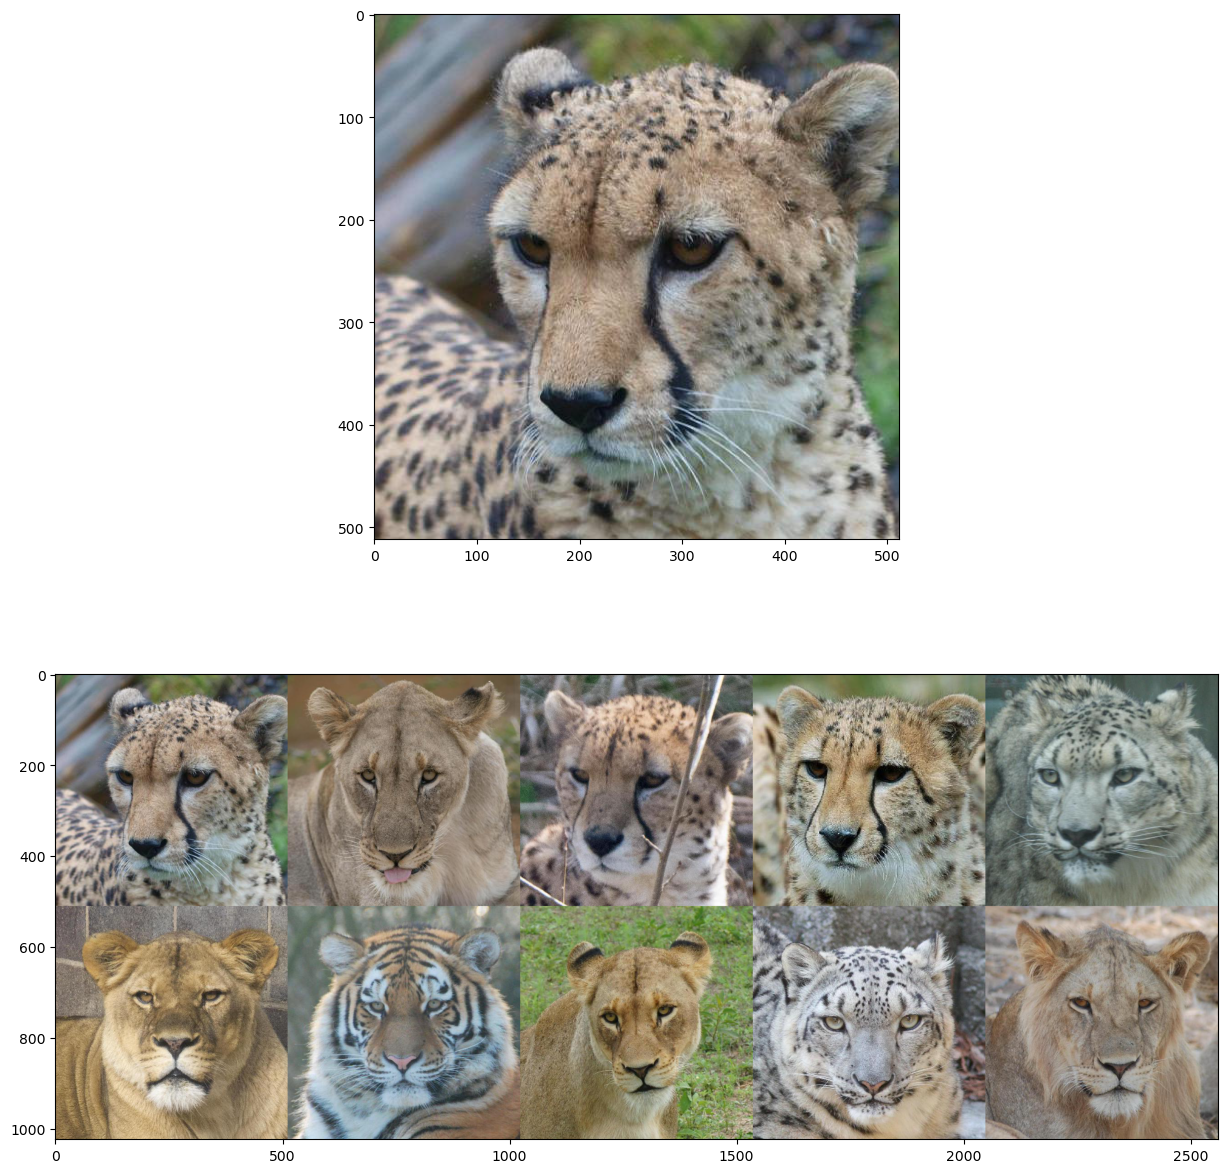

In [37]:
# take the features for the current image, find all similar
# images in our dataset, and then initialize our list of result
# images
fig, ax = plt.subplots(nrows=2,figsize=(15,15))
queryIdx = 3166# Input Index for which images 
MAX_RESULTS = 10


queryFeatures = latent_features[queryIdx]
results = perform_search(queryFeatures, index_dict, maxResults=MAX_RESULTS)
imgs = []

# loop over the results
for (d, j) in results:
    img = np.array(Image.open(images[j]))
    print(j)
    imgs.append(img)

# display the query image
ax[0].imshow(np.array(Image.open(images[queryIdx])))

# build a montage from the results and display it
montage = build_montages(imgs, (512, 512), (5, 2))[0]
ax[1].imshow(montage)